In [106]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sb
import matplotlib
import numpy as np

In [3]:
driver = 'mysql+pymysql:'
user = 'root'
password = '17028854'
ip = '35.195.111.11'
database = 'Avocalypse'

connection_string = f'{driver}//{user}:{password}@{ip}/{database}'
engine = create_engine(connection_string)

# Google searches of "Avocado": On-line popularity

In [4]:
gtrend = pd.read_sql('gtrend',con=engine)

In [5]:
gtrend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 4 columns):
index         183 non-null int64
year          183 non-null object
month         183 non-null object
popularity    183 non-null object
dtypes: int64(1), object(3)
memory usage: 5.8+ KB


In [6]:
gtrend['year'] = gtrend['year'].astype('int64')
gtrend['month'] = gtrend['month'].astype('int64')
gtrend['popularity'] = gtrend['popularity'].astype('int64')

In [107]:
sb.set(rc={'figure.figsize':(15,8)})

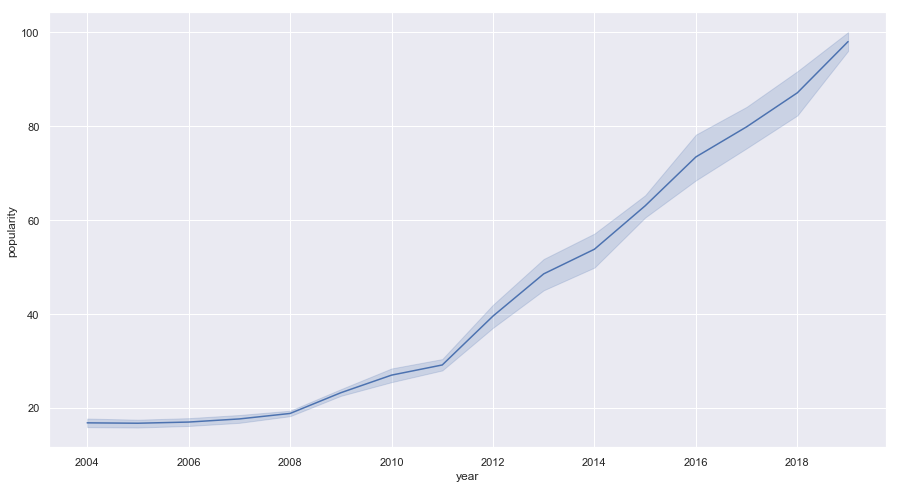

In [8]:
sb.lineplot(data=gtrend, x=gtrend.year, y=gtrend.popularity)

# Production

In [9]:
countries = pd.read_sql('countries',con=engine)
prices = pd.read_sql('prices',con=engine)
production = pd.read_sql('production',con=engine)

In [10]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
index        52 non-null int64
Area         52 non-null object
Area Code    52 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.3+ KB


In [11]:
countries = countries.drop(columns='index')

In [12]:
production.head()

,index,Area Code,Year Code,Total_protuction_t,Area harvested
0,0,9,2007,3600.0,570.0
1,1,9,2008,3500.0,540.0
2,2,9,2009,3600.0,548.0
3,3,9,2010,3726.0,560.0
4,4,9,2011,3840.0,570.0


In [13]:
production = production.drop(columns='index')

In [14]:
production.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 4 columns):
Area Code             759 non-null int64
Year Code             759 non-null int64
Total_protuction_t    745 non-null float64
Area harvested        745 non-null float64
dtypes: float64(2), int64(2)
memory usage: 23.8 KB


In [15]:
production_countries = production.merge(countries, how='left', on='Area Code')

In [16]:
production_countries.head()

,Area Code,Year Code,Total_protuction_t,Area harvested,Area
0,9,2007,3600.0,570.0,Argentina
1,9,2008,3500.0,540.0,Argentina
2,9,2009,3600.0,548.0,Argentina
3,9,2010,3726.0,560.0,Argentina
4,9,2011,3840.0,570.0,Argentina


In [17]:
total_yearly_production = production_countries.groupby('Year Code').sum()['Total_protuction_t']

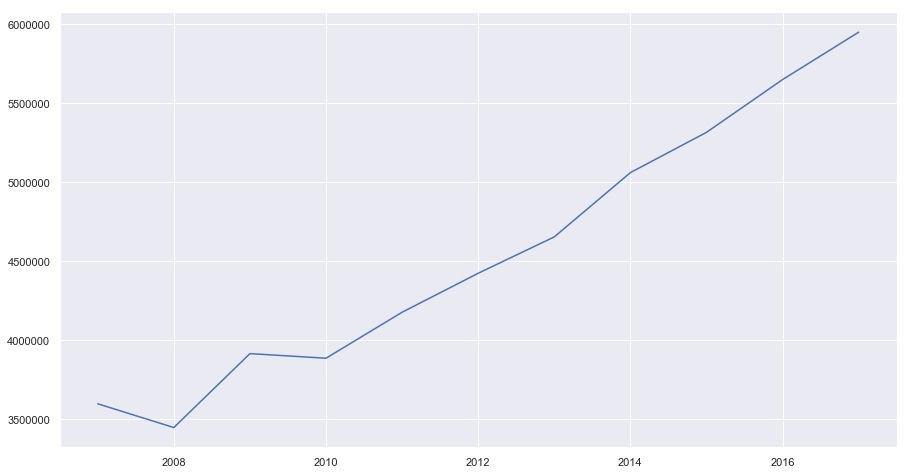

In [18]:
sb.lineplot(data=total_yearly_production)

In [19]:
(total_yearly_production.max()-total_yearly_production.min())/total_yearly_production.min()

0.7272834927115209

In [39]:
production_countries['production_share'] = production_countries['Total_protuction_t'].div(production_countries.groupby('Year Code')['Total_protuction_t'].transform('sum'))

In [60]:
top_10_countries_yearly = production_countries.groupby(['Area','Year Code']).sum().sort_values('Total_protuction_t',ascending=False).head(110)[['Total_protuction_t','Area harvested','production_share']].reset_index()

top10_2016 = top_10_countries_yearly[top_10_countries_yearly['Year Code'] == 2016]



In [61]:
top10_2016['cumulative_share'] = top10_2016['production_share'].cumsum()

/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [63]:
top10_2016 = top10_2016.reset_index(drop=True)

In [64]:
top10_2016

,Area,Year Code,Total_protuction_t,Area harvested,production_share
0,Mexico,2016,1889354.0,180536.0,0.334356
1,Dominican Republic,2016,601349.0,13375.0,0.106420
2,Peru,2016,455394.0,37871.0,0.080590
3,Indonesia,2016,304938.0,23807.0,0.053964
4,Colombia,2016,294389.0,40057.0,0.052097
5,Brazil,2016,196422.0,10907.0,0.034760
6,Kenya,2016,176045.0,10305.0,0.031154
7,Chile,2016,140558.0,29933.0,0.024874
8,Venezuela (Bolivarian Republic of),2016,130290.0,11880.0,0.023057
9,United States of America,2016,124860.0,23200.0,0.022096


We correct by inflation, consumer prices (annual %) extracting data from the World Bank

In [71]:
inflation = pd.DataFrame({'country':['Kenya', 'Mexico', 'Colombia', 'Indonesia', 'Brazil', 'Dominican Republic', 'Peru', 'Chile', 'United States of America', 'China','Venezuela (Bolivarian Republic of)'],'2016_inflation':[8.006,6.041,4.314,3.309,3.446,3.28,2.803,2.182,2.13,1.593,254.949]})


In [65]:
top10_2016.merge(inflation,how='left', left_on='Area',right_on='country')

,Area,Year Code,Total_protuction_t,Area harvested,production_share,country,2017_inflation
0,Mexico,2016,1889354.0,180536.0,0.334356,Mexico,6.041
1,Dominican Republic,2016,601349.0,13375.0,0.106420,Dominican Republic,3.280
2,Peru,2016,455394.0,37871.0,0.080590,Peru,2.803
3,Indonesia,2016,304938.0,23807.0,0.053964,Indonesia,3.309
4,Colombia,2016,294389.0,40057.0,0.052097,Colombia,4.314
5,Brazil,2016,196422.0,10907.0,0.034760,Brazil,3.446
6,Kenya,2016,176045.0,10305.0,0.031154,Kenya,8.006
7,Chile,2016,140558.0,29933.0,0.024874,Chile,2.182
8,Venezuela (Bolivarian Republic of),2016,130290.0,11880.0,0.023057,Venezuela (Bolivarian Republic of),254.949
9,United States of America,2016,124860.0,23200.0,0.022096,United States of America,2.130


We drop Venezuela as it is an outlier considering the inflation in the country

In [36]:
top10_2017 = top10_2017.drop(index=7).reset_index(drop=True)

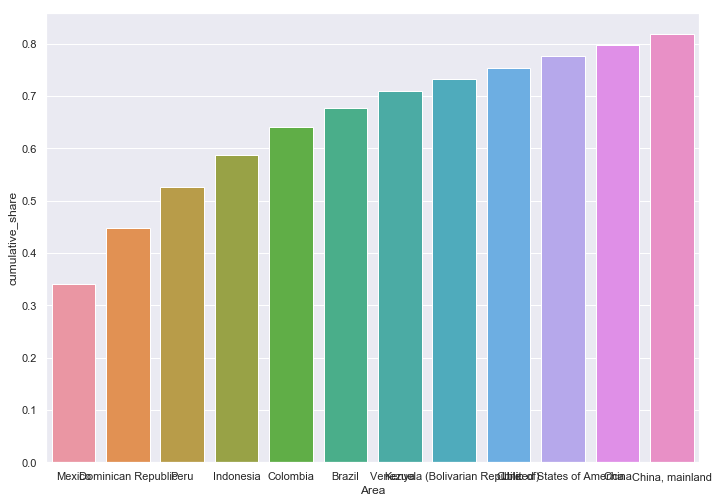

In [247]:
sb.barplot(data=top10_2017,x='Area',y='cumulative_share')

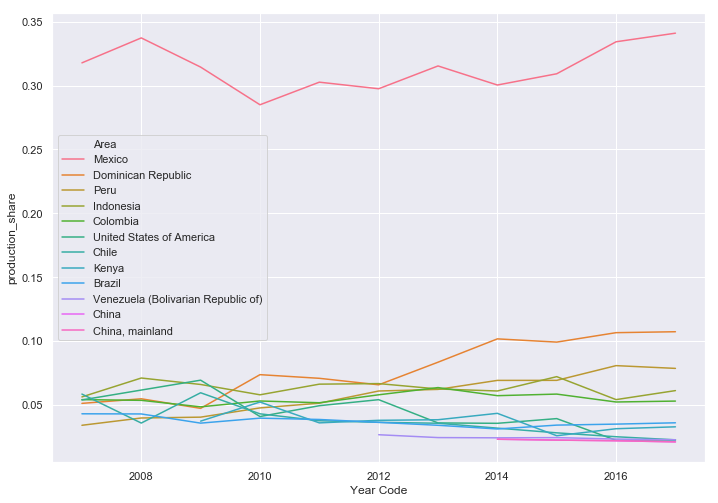

In [228]:
sb.lineplot(data=top_10_countries_yearly,hue='Area',x='Year Code',y='production_share')

# Price

In [50]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 4 columns):
index        527 non-null int64
Area Code    527 non-null int64
Year Code    527 non-null int64
Value        527 non-null float64
dtypes: float64(1), int64(3)
memory usage: 16.5 KB


In [51]:
prices = prices.drop(columns='index')

In [52]:
prices_country = prices.merge(countries, how='left', on='Area Code')

In [53]:
prices_country.head(2)

,Area Code,Year Code,Value,Area
0,9,2007,123.086061,Argentina
1,9,2008,155.952012,Argentina


Select only the Top10 producing countries

In [66]:
list(top10_2016['Area'])

['Mexico',
 'Dominican Republic',
 'Peru',
 'Indonesia',
 'Colombia',
 'Brazil',
 'Kenya',
 'Chile',
 'Venezuela (Bolivarian Republic of)',
 'United States of America',
 'China, mainland',
 'China']

In [67]:
top10_prices = prices_country[prices_country['Area'].isin(list(top10_2016['Area']))]

In [56]:
top10_prices = top10_prices.reset_index(drop=True)

In [68]:
top10_prices_2016 = top10_prices[top10_prices['Year Code']==2016]

We add inflation to correct the increase in value

In [74]:
top10_prices_2016 = top10_prices_2016.merge(inflation,how='left',left_on='Area',right_on='country')

In [76]:
top10_prices_2016['corrected_value']=top10_prices_2016['Value']/top10_prices_2016['2016_inflation']

In [79]:
top10_prices_2016 = top10_prices_2016.drop(index=3).reset_index()

In [82]:
top10_prices_2016 = top10_prices_2016.reset_index(drop=True)

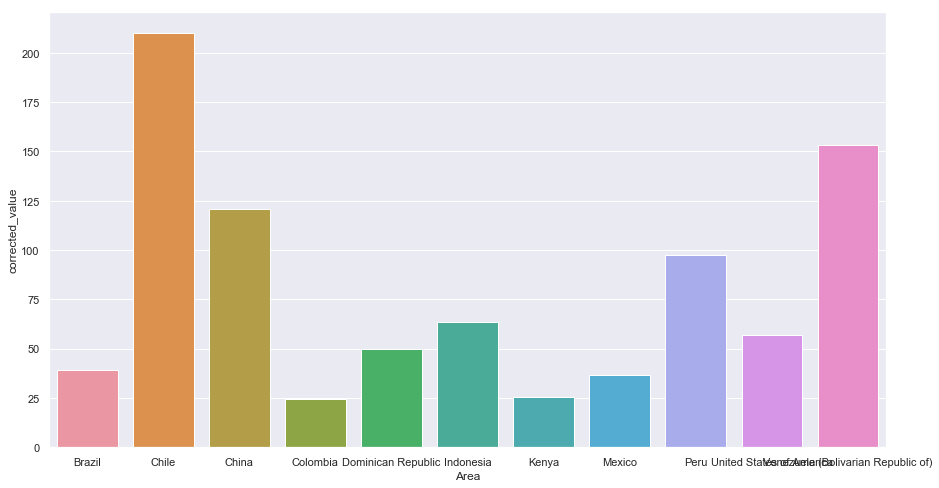

In [109]:
sb.barplot(data=top10_prices_2016,x='Area',y='corrected_value')

The mean to perform the test:

In [110]:
top10_prices_2016['corrected_value'].mean()

79.77191213118039

In [283]:
top10_2016 = top_10_countries_yearly[top_10_countries_yearly['Year Code'] == 2016]


In [289]:
top10_2016_price_prod = top10_2016.merge(top10_prices_2016,on='Area').drop(columns='Year Code_x')

In [292]:
top10_2016_price_prod['Price_ton']=top10_2016_price_prod['Value']*top10_2016_price_prod['Total_protuction_t']/top10_2016_price_prod['Total_protuction_t'].sum()



In [1]:
top10_2016_price_prod

NameError: name 'top10_2016_price_prod' is not defined

In [275]:
top10_2017.merge(top10_prices.group,on=)

,Area,Year Code,Total_protuction_t,Area harvested,production_share,cumulative_share
0,Mexico,2017,2029886.0,188723.0,0.341093,0.341093
11,Dominican Republic,2017,637688.0,14571.0,0.107154,0.448247
15,Peru,2017,466758.0,39489.0,0.078432,0.526679
20,Indonesia,2017,363157.0,28524.0,0.061023,0.587702
22,Colombia,2017,314275.0,39172.0,0.052809,0.640511
47,Brazil,2017,213041.0,12940.0,0.035798,0.676309
55,Kenya,2017,194279.0,11605.0,0.032646,0.708955
91,Venezuela (Bolivarian Republic of),2017,133922.0,11800.0,0.022504,0.731459
92,Chile,2017,133636.0,30078.0,0.022456,0.753914
93,United States of America,2017,132730.0,22900.0,0.022303,0.776218


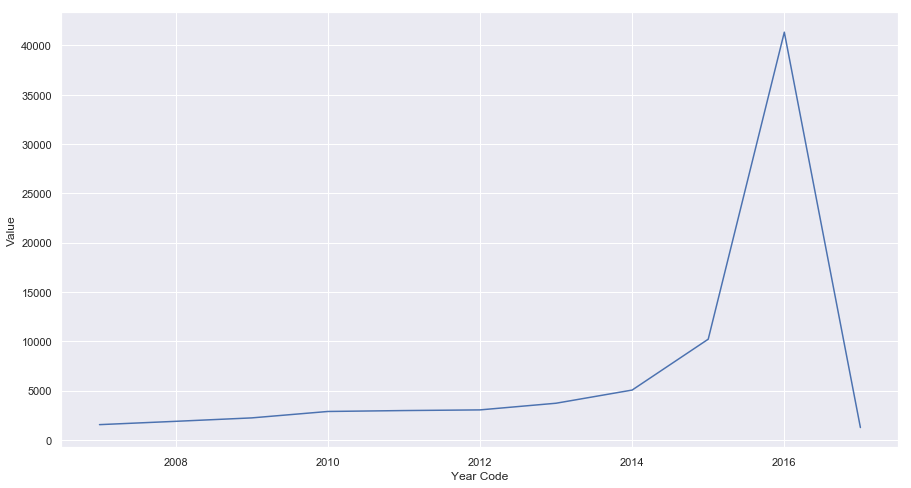

In [273]:
sb.lineplot(data=top10_prices.groupby('Year Code').sum().reset_index(),x='Year Code',y='Value')

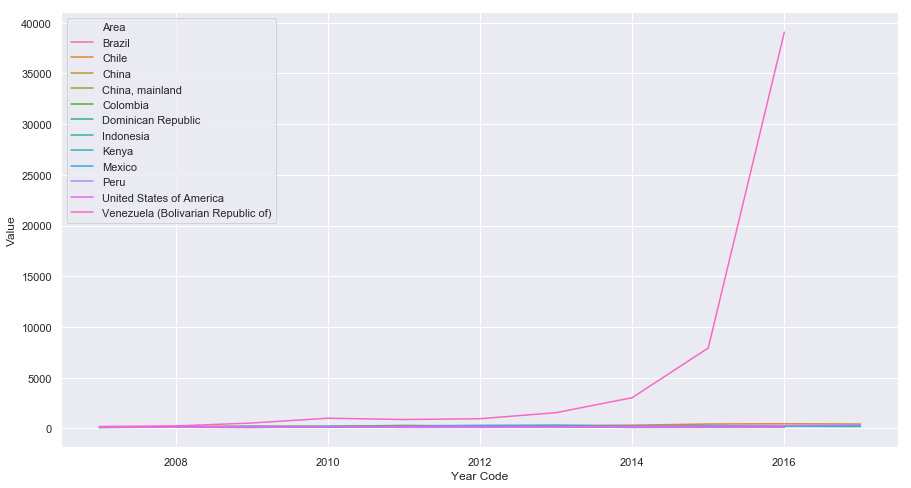

In [264]:
sb.lineplot(data=top10_prices,x='Year Code',y='Value',hue='Area')